# Magazin Sales Dataset - A logistic regression analysis

With this dataset, we will be building a **binary classification model** which will take above inputs as features and predict if the customer will buy the magazine or not. At last, we’ll evaluate our model using the confusion matrix.

#### Data Dictionary
Here are the variables that magazine reseller has on each customer from third-party sources:

- Household Income (Income; rounded to the nearest $1,000.00)
- Gender (IsFemale = 1 if the person is female, 0 otherwise)
- Marital Status (IsMarried = 1 if married, 0 otherwise)
- College Educated (HasCollege = 1 if has one or more years of college education, 0 otherwise)
- Employed in a Profession (IsProfessional = 1 if employed in a profession, 0 otherwise)
- Retired (IsRetired = 1 if retired, 0 otherwise)
- Not employed (Unemployed = 1 if not employed, 0 otherwise)
- Length of Residency in Current City (ResLength; in years)
- Dual Income if Married (Dual = 1 if dual income, 0 otherwise)
- Children (Minors = 1 if children under 18 are in the household, 0 otherwise)
- Home ownership (Own = 1 if own residence, 0 otherwise)
- Resident type (House = 1 if the residence is a single-family house, 0 otherwise)
- Race (White = 1 if the race is white, 0 otherwise)
- Language (English = 1 is the primary language in the household is English, 0 otherwise)

## 1) Import Packages and Dataset

In [246]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [247]:
# Import kid.csv dataset

df = pd.read_csv('kid.csv')
df.shape

(673, 18)

## 2) Data Cleaning

In [248]:
# check head of dataset
df.head(3)

,Obs No.,Buy,Income,Is Female,Is Married,Has College,Is Professional,Is Retired,Unemployed,Residence Length,Dual Income,Minors,Own,House,White,English,Prev Child Mag,Prev Parent Mag
0,1,0,24000,1,0,1,1,0,0,26,0,0,0,1,0,0,0,0
1,2,1,75000,1,1,1,1,0,0,15,1,0,1,1,1,1,1,0
2,3,0,46000,1,1,0,0,0,0,36,1,1,1,1,1,1,0,0


In [249]:
# change columns names to snake_case (lower case letters with underscores instead of whitespaces)

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['obs_no.', 'buy', 'income', 'is_female', 'is_married', 'has_college',
       'is_professional', 'is_retired', 'unemployed', 'residence_length',
       'dual_income', 'minors', 'own', 'house', 'white', 'english',
       'prev_child_mag', 'prev_parent_mag'],
      dtype='object')

In [250]:
# check for duplicates  --> no duplicates
df.duplicated().sum()

0

In [251]:
# remove first column (observation number), since it has no more information than the row index

print(all(list(df.index+1) == df['obs_no.']))  # shows that observation number is equal to index + 1
df.drop(['obs_no.'], axis=1, inplace=True)
df.head(3)

True


,buy,income,is_female,is_married,has_college,is_professional,is_retired,unemployed,residence_length,dual_income,minors,own,house,white,english,prev_child_mag,prev_parent_mag
0,0,24000,1,0,1,1,0,0,26,0,0,0,1,0,0,0,0
1,1,75000,1,1,1,1,0,0,15,1,0,1,1,1,1,1,0
2,0,46000,1,1,0,0,0,0,36,1,1,1,1,1,1,0,0


In [252]:
# check data types 
df.dtypes

buy                 int64
income              int64
is_female           int64
is_married          int64
has_college         int64
is_professional     int64
is_retired          int64
unemployed          int64
residence_length    int64
dual_income         int64
minors              int64
own                 int64
house               int64
white               int64
english             int64
prev_child_mag      int64
prev_parent_mag     int64
dtype: object

All features are of data type *integer*, which seems reasonable considering the data dictionary:
  - 12 categorical variables with only 0/1
  - 2 numeric variables (Household Income - rounded to nearest $1000, Lenth of Residency - rounded to years)

In [253]:
# check for missing data --> no missing data
df.isnull().sum()

buy                 0
income              0
is_female           0
is_married          0
has_college         0
is_professional     0
is_retired          0
unemployed          0
residence_length    0
dual_income         0
minors              0
own                 0
house               0
white               0
english             0
prev_child_mag      0
prev_parent_mag     0
dtype: int64

## 3) Data Exploration & Visualization

### Binary variables: distribution

In [254]:
# make a new dataframe that holds the value counts (0 or 1) for each binary variable

val_counts = pd.DataFrame()
for col in df:
    col_counts = df[col].value_counts().sort_index()     # get value counts for feature
    if list(col_counts.index) == [0, 1]:                 # only include binary features (where index either 0 or 1)
        val_counts = pd.concat([val_counts, df[col].value_counts()], axis=1)
val_counts

,buy,is_female,is_married,has_college,is_professional,is_retired,unemployed,dual_income,minors,own,house,white,english,prev_child_mag,prev_parent_mag
0,548,302,438,478,443,634,652,517,428,429,224,207,61,625,616
1,125,371,235,195,230,39,21,156,245,244,449,466,612,48,57


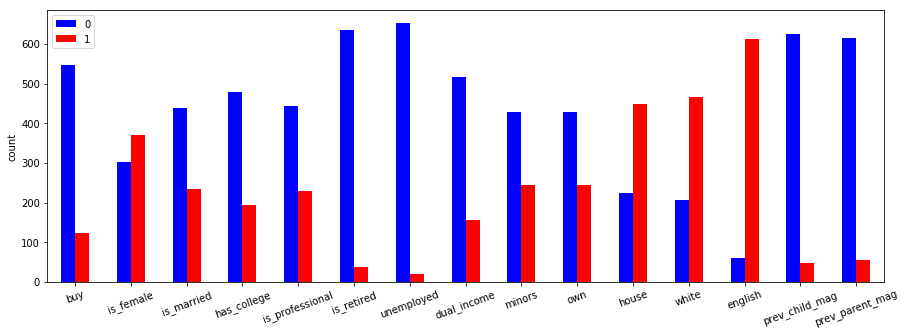

In [255]:
# plot value counts for all binary variables in a bar plot (note: transpose the dataframe for this)
val_counts.T.plot(kind='bar', color=['blue','red'], figsize=(15,5))
plt.xticks(rotation=20)
plt.ylabel('count');

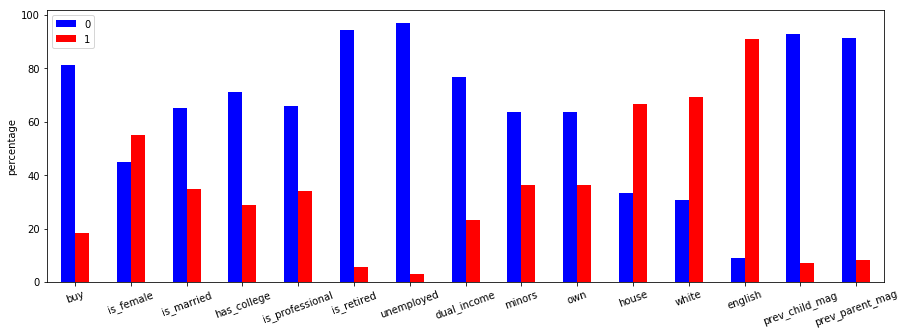

In [256]:
# do the same plot, but with percentage instead of counts
val_percent = val_counts / df.shape[0] * 100
val_percent.T.plot(kind='bar', color=['blue','red'], figsize=(15,5))
plt.xticks(rotation=20)
plt.ylabel('percentage');

### Continuous variables: distribution

In [257]:
# get the name of features in dataframe that are not binary (i.e. that are not plotted above) 

num_cols = [col for col in df.columns if col not in val_counts.columns]
num_cols

['income', 'residence_length']

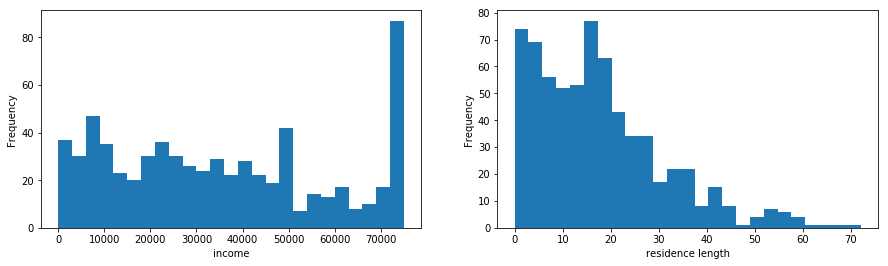

In [258]:
# plot histograms of these features (with matplotlib)
fig, ax = plt.subplots(1,2, figsize=(15,4))

plt.subplot(121)
df.income.plot(kind='hist', bins=25)
plt.xlabel('income');

plt.subplot(122)
df.residence_length.plot(kind='hist', bins=25)
plt.xlabel('residence length');

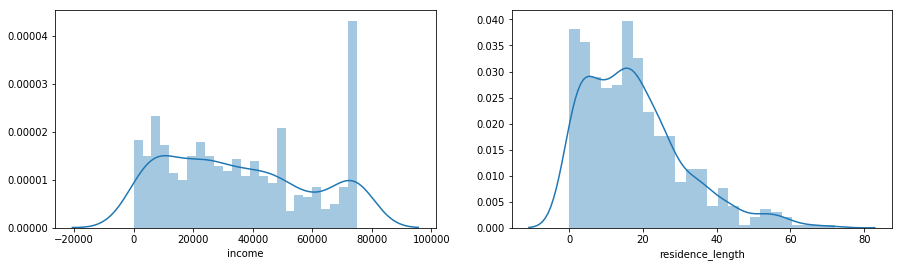

In [259]:
# plot histograms with kde (Gaussian kernel density estimate) with seaborn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # to ignore seaborn warnings

fig, ax = plt.subplots(1,2, figsize=(15,4))

plt.subplot(121)
sns.distplot(df.income, bins=25, kde=True)

plt.subplot(122)
sns.distplot(df.residence_length, bins=25, kde=True);

In [260]:
# calculate skewness and kurtosis for both numerical features
  # skewness (asymmetry) is 0 for normal distribution (<0: tail on right side, >0: tail on left side)
  # excess kurtosis (tailedness) is 0 for normal distribution (cave: Pearsons's kurtosis is excess curtosis + 3)
  #        - <0: platykurtic (fewer/less extreme outliers than ND, e.g. uniform distribution)
  #        - >0: leptokurtic (more/more extreme outliers than ND, e.g. Laplace distribution)

from scipy.stats import kurtosis, skew

for col in num_cols:
    print(col)
    print("  - mean : {:.3f}".format(np.mean(df[col])))
    print("  - var  : {:.3f}".format(np.std(df[col])))
    print("  - skew : {:.3f}".format(skew(df[col])))      
    print("  - kurt : {:.3f}".format(kurtosis(df[col])))  # here: excess kurtosis (is 0 for ND)
    print('')

income
  - mean : 35078.752
  - var  : 23795.089
  - skew : 0.315
  - kurt : -1.121

residence_length
  - mean : 17.618
  - var  : 13.546
  - skew : 1.032
  - kurt : 1.015



We note that `income` varies widely between zero and >70000. There seems to be a maximal income of 75 000 $ in the dataset. The feature is platykurtic, i.e. it has less outliers than the normal distribution and resembles more a uniform distriburtion. 

The `residence_length` varies between 0 and 72 years and the distribution is heavily left-skewed (only few observations with > 40 years of residency). It is leptokurtic, i.e. produces more outliers than the normal distribution.

### Heatmap (correlation matrix)

In [261]:
correlation_matrix = df.corr().round(2)
correlation_matrix

,buy,income,is_female,is_married,has_college,is_professional,is_retired,unemployed,residence_length,dual_income,minors,own,house,white,english,prev_child_mag,prev_parent_mag
buy,1.00,0.68,0.08,0.36,0.20,0.23,-0.02,-0.06,0.16,0.31,0.02,0.38,0.18,0.20,0.08,0.15,0.07
income,0.68,1.00,-0.05,0.43,0.32,0.38,0.03,-0.14,0.20,0.33,-0.10,0.49,0.19,0.20,0.07,0.10,0.08
is_female,0.08,-0.05,1.00,0.07,-0.10,-0.02,0.01,-0.04,0.03,0.04,0.09,0.09,0.03,0.08,0.08,0.04,-0.00
is_married,0.36,0.43,0.07,1.00,0.12,0.10,0.11,-0.06,0.23,0.65,0.06,0.58,0.22,0.06,0.04,0.05,0.01
has_college,0.20,0.32,-0.10,0.12,1.00,0.37,0.04,-0.04,0.01,0.14,-0.21,0.17,-0.10,0.11,0.08,-0.01,0.08
is_professional,0.23,0.38,-0.02,0.10,0.37,1.00,-0.18,-0.13,-0.00,0.18,-0.17,0.17,-0.05,0.11,0.12,0.06,0.01
is_retired,-0.02,0.03,0.01,0.11,0.04,-0.18,1.00,-0.04,0.17,-0.14,-0.13,0.21,0.01,0.10,0.08,-0.04,-0.03
unemployed,-0.06,-0.14,-0.04,-0.06,-0.04,-0.13,-0.04,1.00,-0.02,-0.06,0.06,-0.05,0.04,-0.05,-0.09,-0.02,-0.02
residence_length,0.16,0.20,0.03,0.23,0.01,-0.00,0.17,-0.02,1.00,0.09,-0.01,0.27,0.16,0.01,0.06,0.01,0.03
dual_income,0.31,0.33,0.04,0.65,0.14,0.18,-0.14,-0.06,0.09,1.00,0.02,0.32,0.08,0.02,0.05,0.05,0.09


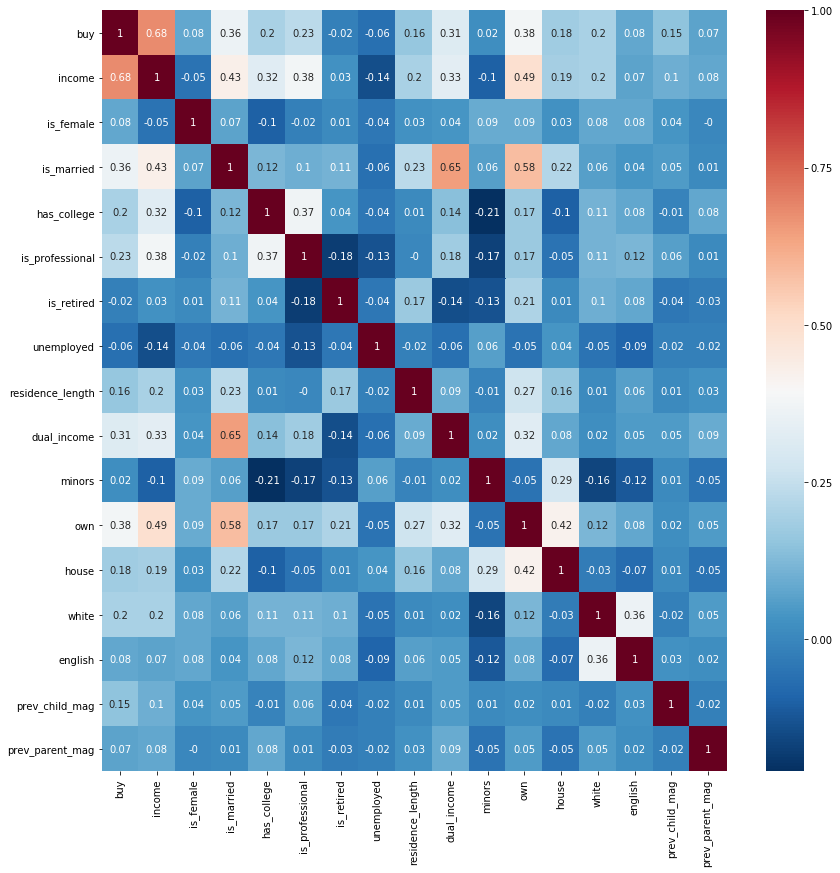

In [262]:
# plot heatmap (correlation matrix)

fig, ax = plt.subplots(figsize=(14,14))
#sns.set(rc={'figure.figsize':(14,14)})

sns.heatmap(data=correlation_matrix, annot=True,  # annot=True  prints the values inside the square
            cmap='RdBu_r'); # square=True, 

### Heatmap (Odds Ratio)

In [263]:
# heatmap with odds ratio instead of Pearson correlation

import scipy.stats as stats
df_binary = df.drop(num_cols, axis=1).copy()
df_odds = pd.DataFrame(index = df_binary.columns,
                       columns = df_binary.columns)

# calculate odds ratio from cross-table for each feature pair and save to new dataframe
for col_i in df_binary:
    for col_j in df_binary:
        odds_table = pd.crosstab(index=df[col_i], columns=df[col_j])
        oddsratio, pvalue = stats.fisher_exact(odds_table.values)
        df_odds.loc[col_i, col_j] = oddsratio
        
df_odds.head(3)

,buy,is_female,is_married,has_college,is_professional,is_retired,unemployed,dual_income,minors,own,house,white,english,prev_child_mag,prev_parent_mag
buy,inf,1.50566,6.48796,2.82393,3.21675,0.78686,0.212903,4.97138,1.11069,7.64094,3.33436,4.31046,2.73171,3.20787,1.81517
is_female,1.50566,inf,1.35652,0.655946,0.928271,1.0568,0.600829,1.22625,1.44022,1.46245,1.1287,1.40564,1.73941,1.38807,0.967873
is_married,6.48796,1.35652,inf,1.6897,1.52302,2.55786,0.428826,46.2427,1.30286,14.9958,2.91806,1.33722,1.31238,1.49377,1.09579


In [264]:
# for exercise: show cross table and odds ratio for one example pair
odds_table = pd.crosstab(index=df['buy'], columns=df['is_female'])
oddsratio, pvalue = stats.fisher_exact(odds_table.values)
odds_table

is_female,0,1
buy,,
0,256,292
1,46,79


In [265]:
# for exercise: calculate odds ratio per hand: 
my_oddsratio = (256/46) / (292/79)  # (male not buy / male buy) / (female not buy / female buy)
my_oddsratio, oddsratio

(1.5056581298391898, 1.50565812983919)

In [266]:
# for exercise: what happens if we switch rows and columns?
odds_table = pd.crosstab(index=df['is_female'], columns=df['buy'])
oddsratio, pvalue = stats.fisher_exact(odds_table.values)
odds_table

buy,0,1
is_female,,
0,256,46
1,292,79


In [267]:
my_oddsratio2 = (256/292) / (46/79)
oddsratio, my_oddsratio2, my_oddsratio

(1.50565812983919, 1.50565812983919, 1.5056581298391898)

In [268]:
# for exercise: check inverse of oddsratio and log(oddsratio) --> the log makes it symmetric around zero!
print(oddsratio, 1/oddsratio)
print(np.log(oddsratio), np.log(1/oddsratio))

1.50565812983919 0.6641613924050633
0.40923009818920725 -0.40923009818920714


In [269]:
# convert all cells from object to float
df_odds.dtypes 
df_odds = df_odds.apply(pd.to_numeric, errors='coerce')

# create new dataframe with log odds
df_log_odds = df_odds.apply(np.log)  # np.log1p
df_log_odds.head(3)

,buy,is_female,is_married,has_college,is_professional,is_retired,unemployed,dual_income,minors,own,house,white,english,prev_child_mag,prev_parent_mag
buy,inf,0.409230,1.869948,1.038130,1.168371,-0.239705,-1.546918,1.603698,0.104978,2.033520,1.204280,1.461045,1.004927,1.165608,0.596180
is_female,0.409230,inf,0.304924,-0.421677,-0.074431,0.055246,-0.509445,0.203964,0.364797,0.380111,0.121062,0.340495,0.553547,0.327917,-0.032654
is_married,1.869948,0.304924,inf,0.524549,0.420692,0.939170,-0.846704,3.833904,0.264560,2.707769,1.070919,0.290593,0.271840,0.401303,0.091480


In [270]:
# create new dataframe in which odds ratios below 1 are converted to negative inverse
df_odds_sym = df_odds.copy()
df_odds_sym[df_odds_sym < 1] = -1 / df_odds_sym[df_odds_sym <= 1]
df_odds_sym.head()

,buy,is_female,is_married,has_college,is_professional,is_retired,unemployed,dual_income,minors,own,house,white,english,prev_child_mag,prev_parent_mag
buy,inf,1.505658,6.487957,2.823932,3.216748,-1.270874,-4.696970,4.971384,1.110686,7.640935,3.334356,4.310463,2.731707,3.207872,1.815171
is_female,1.505658,inf,1.356522,-1.524516,-1.077271,1.056801,-1.664368,1.226254,1.440221,1.462447,1.128695,1.405643,1.739412,1.388074,-1.033193
is_married,6.487957,1.356522,inf,1.689697,1.523016,2.557857,-2.331948,46.242704,1.302857,14.995785,2.918061,1.337221,1.312377,1.493769,1.095794
has_college,2.823932,-1.524516,1.689697,inf,5.352727,1.401547,-1.760846,1.975806,-2.909799,2.162162,-1.564031,1.708861,1.954121,-1.106095,1.746238
is_professional,3.216748,-1.077271,1.523016,5.352727,inf,-inf,-inf,2.401316,-2.237633,2.113806,-1.245205,1.719540,2.862245,1.548113,1.045045


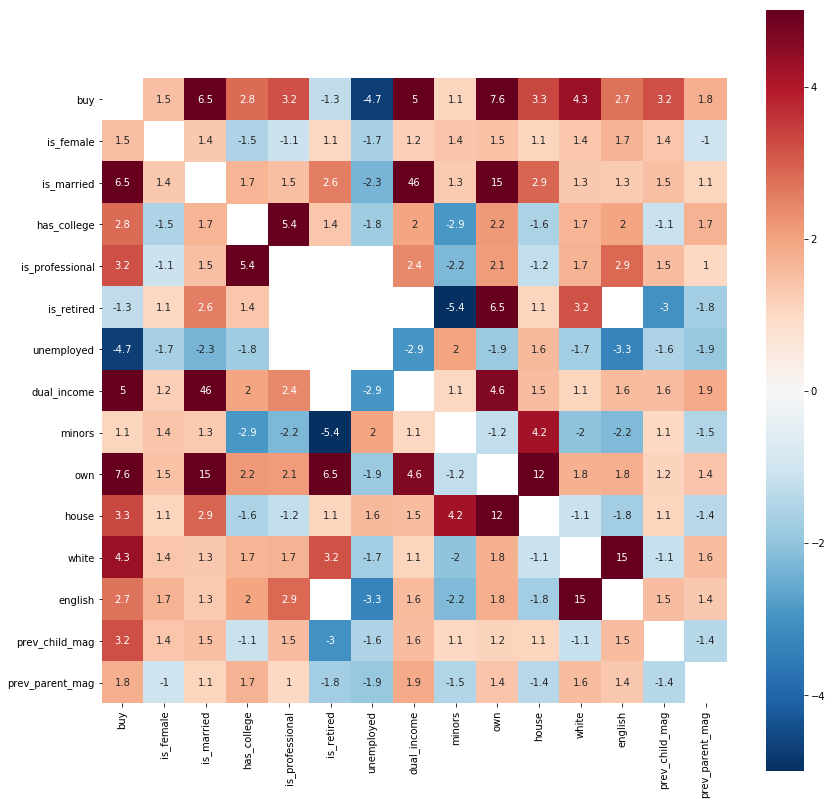

In [271]:
# plot heatmap with odds, symmetric odds, or log odds

fig, ax = plt.subplots(figsize=(14,14))
#sns.heatmap(data=df_odds, annot=True, cmap='Reds', vmin = 0, vmax = 10, square=True);   # OrRd
sns.heatmap(data=df_odds_sym, annot=True, cmap='RdBu_r', vmin=-5, vmax=5, square=True);

Some observations from this heatmap: 
- The odds of buying are **much higher** (>4 times) if: married, dual income, own house, white
- The odds of buying are **slightly higher** if: female, has college, is professional, english, single family house
- The odds of buying are **much lower** (>4 times) if: unemployed
- The odds of buying are **slightly lower** if: retired

Besides, some other strong **positive** relationships include: white and english, dual income and married, has college and is professional, own house and single family house.<br>
Some other strong **negative** relationships include: being retired and having minors in the house

## Logistic Regression

### Multivariate logistic regression

In [272]:
# dependent variable
y = df.buy

# independent variables
X = df.drop('buy', axis=1)

In [273]:
# Prior to training our model, we’ll set aside a portion of our data in order to evaluate its performance

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((504, 16), (169, 16), (504,), (169,))

In [274]:
# We instantiate an instance of the LogisticRegression class and call the fit function with the features 
# and the labels (since Logistic Regression is a supervised machine learning algorithm) as arguments.

from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(solver='liblinear')  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [275]:
# We can access the following properties to actually view the coefficient for the slope and y-intercept 
# of the best fitting model.
print(logr.coef_)
print(logr.intercept_)

[[ 7.78902068e-05 -2.19293273e-01  3.21178677e-01 -1.53624060e-01
  -2.72363528e-01 -2.40768365e-01 -1.32884938e-01 -1.49845559e-02
   4.12513356e-01 -5.44759022e-01  6.16026857e-01 -7.07704623e-01
  -3.23867113e-01 -1.47298253e+00  1.63694071e-01 -5.05241202e-02]]
[-2.7631717]


In [276]:
# Let’s see how the model performs against data that it hasn’t been trained on.

y_pred = logr.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 0])

In [277]:
# now we have for each sample in test set one true and one predicted label
y_test.values[:5], y_pred[:5]

(array([0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0]))

In [278]:
# If for whatever reason we’d like to check the actual probability that a data 
# point belongs to a given class, we can use the predict_proba function.
# first column is probability of y=0, second column is probability of y=1 (for a given x value = row)

y_pred_proba = logr.predict_proba(X_test)
y_pred_proba[:5]

array([[0.74671543, 0.25328457],
       [0.58933422, 0.41066578],
       [0.86693497, 0.13306503],
       [0.71046273, 0.28953727],
       [0.99794909, 0.00205091]])

In [279]:
# The first column corresponds to the probability that the sample belongs to the first class and the
# second column corresponds to the probability that the sample belongs to the second class.
# Hence, the sum over all columns should give a probability of one (for each row). Check this:

all(np.sum(y_pred_proba, axis=1)==1)

True

In [280]:
# Given that this consists of a classification problem, 
# we use a confusion matrix to measure the accuracy of our model.

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

conf_matrix = confusion_matrix(y_test, y_pred)  # tn, fp, fn, tp
conf_matrix

array([[130,   2],
       [ 13,  24]])

In [281]:
TN, FP, FN, TP = conf_matrix.ravel()
# TN = 126, FP = 6
# FN = 25,  TP = 12

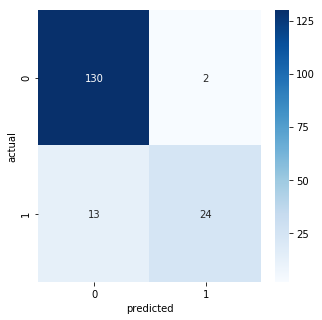

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       132
           1       0.92      0.65      0.76        37

    accuracy                           0.91       169
   macro avg       0.92      0.82      0.85       169
weighted avg       0.91      0.91      0.91       169



In [282]:
# plot confusion matrix with seaborn

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0f');  # use fmt to suppress scientific notation
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show(); 

# and show full classification report below
print(classification_report(y_test, y_pred))

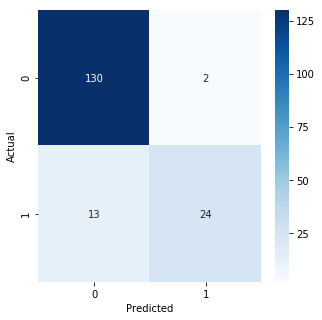

In [283]:
# for exercise: build own confusion matrix

conf_matrix_own = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_matrix_own, annot=True, cmap='Blues', fmt='.0f');

In [284]:
# calculate accuracy using sklearn metrics [ Accuracy = (TP + TN) / (TP + TN + FP + FN) ]
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.9112426035502958


In [285]:
# for exercise: calculate accuracy by hand
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
Acc = (TP + TN) / conf_matrix.sum().sum()
Acc

0.9112426035502958

In [286]:
# ToDo: play around with threshold and plot ROC curve of model

### ROC curves

In [287]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

The `roc_curve` function returns three lists:
    - thresholds = all unique prediction probabilities in descending order
    - fpr = the false positive rate (FP / (FP+TN)) for each threshold
    - tpr = the true positive rate  (TP / (TP+FN)) (i.e. recall) for each threshold

In [288]:
thresholds

array([1.95581551e+00, 9.55815514e-01, 7.90378719e-01, 7.73939381e-01,
       5.08716185e-01, 5.04347752e-01, 4.56666234e-01, 4.06971747e-01,
       3.93832225e-01, 3.31489101e-01, 3.28032274e-01, 3.21475070e-01,
       2.92063388e-01, 2.68022852e-01, 2.64344263e-01, 2.29620856e-01,
       2.21317491e-01, 1.63704301e-01, 1.56984355e-01, 1.18809933e-01,
       1.18385541e-01, 1.14578538e-01, 1.12186974e-01, 7.50350712e-02,
       7.49117332e-02, 1.94302943e-03])

We can plot the ROC curve for each model as shown below.

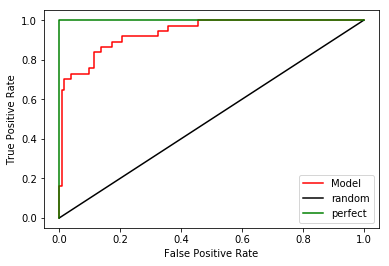

In [289]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr,'r-',label = 'Model')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

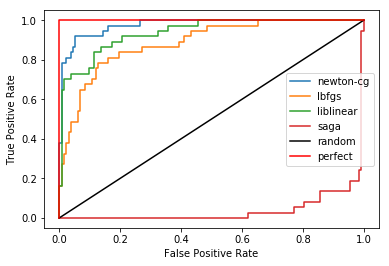

In [290]:
# Do the same in one cell to test different solvers of the Logistic Regression algorithm

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']  # 'sag', 

for sol in solvers:
    logr = LogisticRegression(solver=sol)  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
    logr.fit(X_train, y_train)
    y_pred_proba = logr.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

    plt.plot(fpr, tpr,'-',label=sol)
    
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'r-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

### Simple logistic regression (buy ~ own)

In [291]:
# For exercise: Fit logistic regression for only one independent variable

# get the binary variable with highest regression coefficient in the multivariate logistic regression (see above)
X.columns[logr.coef_.argmax()]    # or: X.iloc[:,logr.coef_.argmax()].name

'dual_income'

In [292]:
# do simple logistic regression with only 'own' as independent variable (first for entire dataset before CV)
x = df.own.to_frame()
y = df.buy

logr_s = LogisticRegression(solver='lbfgs') #liblinear')  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
logr_s.fit(x, y)
logr_s.coef_, logr_s.intercept_

(array([[1.93610857]]), array([-2.45456779]))

In [293]:
# for exercise: show cross table for 'own' with 'buy' and compute oddsratio and logodds
odds_table = pd.crosstab(index=df['buy'], columns=df['own'])
oddsratio, pvalue = stats.fisher_exact(odds_table.values)
my_oddsratio = (397/32) / (151/93)  #  (not_own|not_buy / not_own/buy) / (own|not_buy / own|buy)
print(oddsratio, my_oddsratio, np.log(oddsratio))
odds_table

7.640935430463577 7.640935430463577 2.0335200342257957


own,0,1
buy,,
0,397,151
1,32,93


In [294]:
# calculate separate odds for each class (own, non-own):
print(93/151)  # for own  (should be the same as exp(intercept + slope) of logistic regression)
print(32/397)  # for non-own  (should be the same as exp(intercept) of logistic regression)
print(np.log(oddsratio))  # log oddsratio should be the same as beta1 (slope) of logistic regression (see below)

0.6158940397350994
0.08060453400503778
2.0335200342257957


In [295]:
# Check transformations between odds ratio, odds, and logit (log odds):
# https://user.demogr.mpg.de/doblhammer/logreg.pdf
  # Odds = p/1-p = 0.20/0.80 = 0.25
  # Logit = ln(Odds) = ln(0.25) = -1.386
  # Odds = exp(Logit) = exp(-1.386)=0.25

print(np.exp(logr_s.coef_[0] + logr_s.intercept_))  # for own
print(np.exp(logr_s.intercept_))  # for non-own
print(logr_s.coef_[0])

[0.59543728]
[0.08590031]
[1.93610857]


In [296]:
# Now do the same, but with cross validation (train/test splitting) to compute confusion matrix
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((504, 1), (169, 1), (504,), (169,))

In [297]:
# We instantiate an instance of the LogisticRegression class and call the fit function with the features 
# and the labels (since Logistic Regression is a supervised machine learning algorithm) as arguments.

from sklearn.linear_model import LogisticRegression

logr_s = LogisticRegression(solver='liblinear')  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
logr_s.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [298]:
# We can check the coefficient for the slope and y-intercept of the best fitting model.
print(logr_s.coef_)
print(logr_s.intercept_)

[[1.86448362]]
[-2.45754917]


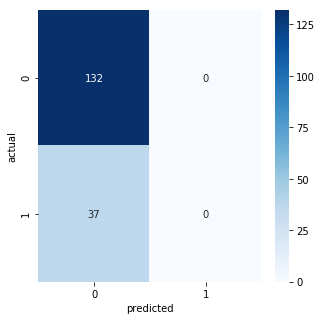

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       132
           1       0.00      0.00      0.00        37

    accuracy                           0.78       169
   macro avg       0.39      0.50      0.44       169
weighted avg       0.61      0.78      0.69       169



In [299]:
# Let’s see the confusion matrix and classification report for this simple logistic regression

y_pred = logr_s.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0f');  # use fmt to suppress scientific notation
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show();

print(classification_report(y_test, y_pred))

### Simple logistic regression (buy ~ income)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       132
           1       0.96      0.70      0.81        37

    accuracy                           0.93       169
   macro avg       0.94      0.85      0.88       169
weighted avg       0.93      0.93      0.92       169



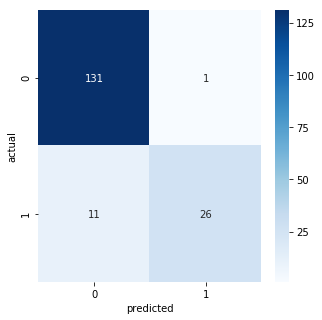

In [300]:
# repeat the simple logistic regression for a continuous (not a binary) independent variable
x = df.income.to_frame()
y = df.buy

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
logr_s = LogisticRegression(solver='liblinear')  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
logr_s.fit(x_train, y_train)

y_pred = logr_s.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0f');  # use fmt to suppress scientific notation
plt.xlabel('predicted')
plt.ylabel('actual');

print(classification_report(y_test, y_pred))

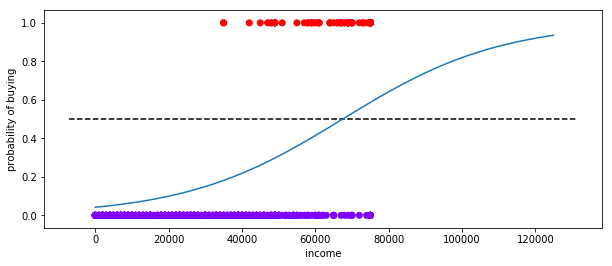

In [301]:
# Using the sigmoid (expit) function, we calculate for different x the probability to belong to class y=1 and plot it

from scipy.special import expit
# The expit function, also known as the logistic function, is defined as
# expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function.

x_plot = np.linspace(0,125000, 125000)
regression_function = x_plot * logr_s.coef_[0][0] + logr_s.intercept_[0]  
sigmoid_function = expit(regression_function).ravel()  # ravel flattens the data to an ndarray - from (25,) to (25,)?

# or:
# regression_function = df.income * logr_s.coef_[0][0] + logr_s.intercept_[0]  
# sigmoid_function = expit(regression_function).ravel()  # ravel flattens the data to an ndarray - from (25,) to (25,)?
# sigm = pd.DataFrame(sigmoid_function, index=None, columns=['sigmoid'])
# neu = pd.concat([df.income, sigm], axis=1)
# neu.sort_values(by='income',inplace=True)
# plt.plot(neu.income, neu.sigmoid)

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(x_plot, sigmoid_function)
plt.scatter(df.income, df.buy, c=df.buy, cmap='rainbow')
plt.hlines(0.5, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linestyles='dashed')
plt.xlabel('income')
plt.ylabel('probability of buying');

### Simple logistic regression (buy ~ residence_length)

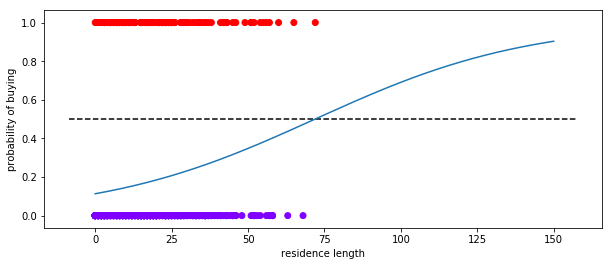

In [302]:
# repeat with the other continuous independent variable: residence_length
x = df.residence_length.to_frame()
y = df.buy

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
logr_s = LogisticRegression(solver='liblinear')  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
logr_s.fit(x_train, y_train)

x_plot = np.linspace(0,150,1000)
regression_function = x_plot * logr_s.coef_[0][0] + logr_s.intercept_[0]  
sigmoid_function = expit(regression_function).ravel()

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(x_plot, sigmoid_function)
plt.scatter(df.residence_length, df.buy, c=df.buy, cmap='rainbow') 
plt.hlines(0.5, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linestyles='dashed')
plt.xlabel('residence length')
plt.ylabel('probability of buying');

### Simple logistic regression (buy ~ own)

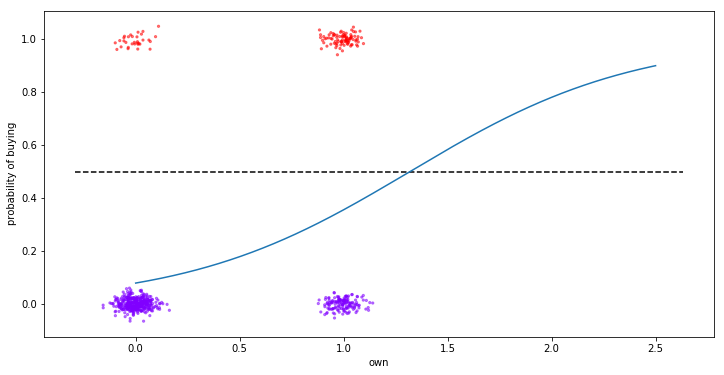

In [305]:
x = df.own.to_frame()
y = df.buy

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
logr_s = LogisticRegression(solver='liblinear')  # Default solver will change from ‘liblinear’ to ‘lbfgs’ in 0.22.
logr_s.fit(x_train, y_train)

# get function to include jitter in plots (adapted from stackoverflow)
         # https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-
         # datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr, strength):
    stdev = strength*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

x_plot = np.linspace(0,2.5,1000)
regression_function = x_plot * logr_s.coef_[0][0] + logr_s.intercept_[0]  
sigmoid_function = expit(regression_function).ravel()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(x_plot, sigmoid_function)

plt.scatter(rand_jitter(df.own, 0.05), rand_jitter(df.buy, 0.02), alpha=0.5, s=5, c=df.buy, cmap='rainbow') 
plt.hlines(0.5, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linestyles='dashed')
plt.xlabel('own')
plt.ylabel('probability of buying');
